LSTM model for long-term forecasting -- up to 6 months ahead

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

## 1. Data preprocessing

- database connection
- expand_data
- aggregation - avg?
- df[['utilization']]
- TimeSeriesDataset

In [3]:
import psycopg2

# Connect to the PostgreSQL database
conn = psycopg2.connect(
    host="...",
    database="...",
    user="...",
    password="..."
)

# Create a cursor object to interact with the database
cursor = conn.cursor()

# Execute a SELECT query to fetch data from a table
query = "SELECT * FROM station_data_hour"
cursor.execute(query)

# Fetch all rows from the result set
rows = cursor.fetchall()

# Get the column names from the cursor description
columns = [desc[0] for desc in cursor.description]

# Create a Pandas DataFrame with the fetched data and column names
df = pd.DataFrame(rows, columns=columns)

# Close the cursor and connection
cursor.close()
conn.close()

# Print the DataFrame
print(df.head())


   location_id location_friendlyname location_friendlycode  \
0       120945      Opatija Lipovica           HRHEP-51001   
1       120945      Opatija Lipovica           HRHEP-51001   
2       120945      Opatija Lipovica           HRHEP-51001   
3       120945      Opatija Lipovica           HRHEP-51001   
4       120945      Opatija Lipovica           HRHEP-51001   

  location_address_cityname  location_address_postnumber  \
0                   Opatija                        51410   
1                   Opatija                        51410   
2                   Opatija                        51410   
3                   Opatija                        51410   
4                   Opatija                        51410   

  location_address_streetname location_address_housenumber  \
0                    Lipovica                           bb   
1                    Lipovica                           bb   
2                    Lipovica                           bb   
3                 

In [4]:
def filter_csv_by_first_column(df, value):
    '''inputs: csv_file - file with measurements (from database), value - ID'''
        
    # Filter rows based on the first column value, save the name of the station
    filtered_df = df[df.iloc[:, 0] == value]
    name = str(filtered_df.iloc[0, 1])
    print('Station: ', name)
    
    # eliminate the columns 1 to 6 that pertain to the location (address, street number etc.) 
    #filtered_df = filtered_df.iloc[:, 7:]
    
    return filtered_df, name


In [5]:
# Call the function to filter the CSV
filtered_data_zg, name2 = filter_csv_by_first_column(df, 140631)
filtered_data_zg

Station:  Zagreb Autobusni


,location_id,location_friendlyname,location_friendlycode,location_address_cityname,location_address_postnumber,location_address_streetname,location_address_housenumber,location_accesstype_title,charging_hour,utilization,connector_count,congested_connectors,energy_consumption,charging_minutes
114294,140631,Zagreb Autobusni,HRHEP-01005,Zagreb,10000,Botićev trg,bb,Public access - Free access,2019-09-13 13:00:00+00:00,2.575758,11,0,10.991273,17
114295,140631,Zagreb Autobusni,HRHEP-01005,Zagreb,10000,Botićev trg,bb,Public access - Free access,2019-09-13 16:00:00+00:00,2.424242,11,0,7.990878,16
114296,140631,Zagreb Autobusni,HRHEP-01005,Zagreb,10000,Botićev trg,bb,Public access - Free access,2019-09-13 17:00:00+00:00,2.121212,11,0,6.992018,14
114297,140631,Zagreb Autobusni,HRHEP-01005,Zagreb,10000,Botićev trg,bb,Public access - Free access,2019-09-14 03:00:00+00:00,3.030303,11,0,13.496073,20
114298,140631,Zagreb Autobusni,HRHEP-01005,Zagreb,10000,Botićev trg,bb,Public access - Free access,2019-09-14 04:00:00+00:00,0.909091,11,0,4.048822,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125604,140631,Zagreb Autobusni,HRHEP-01005,Zagreb,10000,Botićev trg,bb,Public access - Free access,2022-10-30 21:00:00+00:00,3.181818,11,0,15.337260,21
125605,140631,Zagreb Autobusni,HRHEP-01005,Zagreb,10000,Botićev trg,bb,Public access - Free access,2022-10-31 01:00:00+00:00,17.121212,11,0,18.376942,113
125606,140631,Zagreb Autobusni,HRHEP-01005,Zagreb,10000,Botićev trg,bb,Public access - Free access,2022-10-31 02:00:00+00:00,13.333333,11,0,21.162793,88
125607,140631,Zagreb Autobusni,HRHEP-01005,Zagreb,10000,Botićev trg,bb,Public access - Free access,2022-10-31 13:00:00+00:00,5.151515,11,0,6.989488,34


In [6]:
# dropping the unnecessary columns
filtered_data_zg.drop(columns=['location_friendlycode',
                                           'location_address_cityname',
                                          'location_address_postnumber',
                                          'location_address_streetname',
                                          'location_address_housenumber'], axis=1, inplace=True)
filtered_data_zg

C:\Users\ZVNE\AppData\Local\Temp\ipykernel_24484\1731163530.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_zg.drop(columns=['location_friendlycode',


,location_id,location_friendlyname,location_accesstype_title,charging_hour,utilization,connector_count,congested_connectors,energy_consumption,charging_minutes
114294,140631,Zagreb Autobusni,Public access - Free access,2019-09-13 13:00:00+00:00,2.575758,11,0,10.991273,17
114295,140631,Zagreb Autobusni,Public access - Free access,2019-09-13 16:00:00+00:00,2.424242,11,0,7.990878,16
114296,140631,Zagreb Autobusni,Public access - Free access,2019-09-13 17:00:00+00:00,2.121212,11,0,6.992018,14
114297,140631,Zagreb Autobusni,Public access - Free access,2019-09-14 03:00:00+00:00,3.030303,11,0,13.496073,20
114298,140631,Zagreb Autobusni,Public access - Free access,2019-09-14 04:00:00+00:00,0.909091,11,0,4.048822,6
...,...,...,...,...,...,...,...,...,...
125604,140631,Zagreb Autobusni,Public access - Free access,2022-10-30 21:00:00+00:00,3.181818,11,0,15.337260,21
125605,140631,Zagreb Autobusni,Public access - Free access,2022-10-31 01:00:00+00:00,17.121212,11,0,18.376942,113
125606,140631,Zagreb Autobusni,Public access - Free access,2022-10-31 02:00:00+00:00,13.333333,11,0,21.162793,88
125607,140631,Zagreb Autobusni,Public access - Free access,2022-10-31 13:00:00+00:00,5.151515,11,0,6.989488,34


In [7]:
def expand_data(dataframe):
    # function that expands original dataframe with all time stamps
    '''inputs: original dataframe with values for ONE station'''
    
    dataframe_copy = dataframe.copy()
    dataframe_sorted = dataframe_copy.sort_values('location_friendlyname')
    dataframe_sorted['Time'] = pd.to_datetime(dataframe_sorted['charging_hour'], format='%Y-%m-%d %H:%M:%S').dt.tz_localize(None)
    list_names = dataframe_sorted['location_friendlyname'].unique()
    indices_all = []
    dfs = []
    
    for name in list_names:
        dataframe_slice = dataframe_sorted.loc[dataframe_copy['location_friendlyname'] == str(name)].copy().reset_index(drop=True)

        # create new dataframe with index as every hour        
        start_index = dataframe_slice['Time'].min() #starting point is the day of the first index
        end_index = dataframe_slice['Time'].max() # ending pojnt is the day of the last index
        indices = pd.date_range(start_index, end_index, freq='1H')
        indices_all.extend(indices)
        
        dataframe_slice.set_index('Time', inplace=True)
        new_dataframe = pd.DataFrame(index=indices, data=dataframe_slice)

        new_dataframe['Time'] = new_dataframe.index
        new_dataframe['location_id'] = new_dataframe['location_id'].fillna(dataframe_slice['location_id'][0])
        new_dataframe['location_friendlyname'] = new_dataframe['location_friendlyname'].fillna(dataframe_slice['location_friendlyname'][0])
        new_dataframe['location_accesstype_title'] = new_dataframe['location_accesstype_title'].fillna(dataframe_slice['location_accesstype_title'][0])
        new_dataframe['charging_hour'] = new_dataframe['charging_hour'].fillna(np.nan) 
        # charging_hour column is filled with Nan values because it will be later dropped and is not necessary
        
        new_dataframe['utilization'] = new_dataframe['utilization'].fillna(0.0)
        new_dataframe['connector_count'] = new_dataframe['connector_count'].fillna(dataframe_slice['connector_count'][0])
        new_dataframe['congested_connectors'] = new_dataframe['congested_connectors'].fillna(0.0)
        new_dataframe['energy_consumption'] = new_dataframe['energy_consumption'].fillna(0.0)
        new_dataframe['charging_minutes'] = new_dataframe['charging_minutes'].fillna(0.0)
        dfs.append(new_dataframe)
        
    dataframe_total_exp = pd.concat(dfs, ignore_index=True)
    
    return dataframe_total_exp

In [8]:
expanded_data_all = expand_data(filtered_data_zg)
expanded_data_all

,location_id,location_friendlyname,location_accesstype_title,charging_hour,utilization,connector_count,congested_connectors,energy_consumption,charging_minutes,Time
0,140631.0,Zagreb Autobusni,Public access - Free access,2019-09-13 13:00:00+00:00,2.575758,11.0,0.0,10.991273,17.0,2019-09-13 13:00:00
1,140631.0,Zagreb Autobusni,Public access - Free access,NaT,0.000000,11.0,0.0,0.000000,0.0,2019-09-13 14:00:00
2,140631.0,Zagreb Autobusni,Public access - Free access,NaT,0.000000,11.0,0.0,0.000000,0.0,2019-09-13 15:00:00
3,140631.0,Zagreb Autobusni,Public access - Free access,2019-09-13 16:00:00+00:00,2.424242,11.0,0.0,7.990878,16.0,2019-09-13 16:00:00
4,140631.0,Zagreb Autobusni,Public access - Free access,2019-09-13 17:00:00+00:00,2.121212,11.0,0.0,6.992018,14.0,2019-09-13 17:00:00
...,...,...,...,...,...,...,...,...,...,...
27453,140631.0,Zagreb Autobusni,Public access - Free access,NaT,0.000000,11.0,0.0,0.000000,0.0,2022-10-31 10:00:00
27454,140631.0,Zagreb Autobusni,Public access - Free access,NaT,0.000000,11.0,0.0,0.000000,0.0,2022-10-31 11:00:00
27455,140631.0,Zagreb Autobusni,Public access - Free access,NaT,0.000000,11.0,0.0,0.000000,0.0,2022-10-31 12:00:00
27456,140631.0,Zagreb Autobusni,Public access - Free access,2022-10-31 13:00:00+00:00,5.151515,11.0,0.0,6.989488,34.0,2022-10-31 13:00:00


In [9]:
expanded_data_all.set_index('Time', inplace=True)
expanded_data_all

,location_id,location_friendlyname,location_accesstype_title,charging_hour,utilization,connector_count,congested_connectors,energy_consumption,charging_minutes
Time,,,,,,,,,
2019-09-13 13:00:00,140631.0,Zagreb Autobusni,Public access - Free access,2019-09-13 13:00:00+00:00,2.575758,11.0,0.0,10.991273,17.0
2019-09-13 14:00:00,140631.0,Zagreb Autobusni,Public access - Free access,NaT,0.000000,11.0,0.0,0.000000,0.0
2019-09-13 15:00:00,140631.0,Zagreb Autobusni,Public access - Free access,NaT,0.000000,11.0,0.0,0.000000,0.0
2019-09-13 16:00:00,140631.0,Zagreb Autobusni,Public access - Free access,2019-09-13 16:00:00+00:00,2.424242,11.0,0.0,7.990878,16.0
2019-09-13 17:00:00,140631.0,Zagreb Autobusni,Public access - Free access,2019-09-13 17:00:00+00:00,2.121212,11.0,0.0,6.992018,14.0
...,...,...,...,...,...,...,...,...,...
2022-10-31 10:00:00,140631.0,Zagreb Autobusni,Public access - Free access,NaT,0.000000,11.0,0.0,0.000000,0.0
2022-10-31 11:00:00,140631.0,Zagreb Autobusni,Public access - Free access,NaT,0.000000,11.0,0.0,0.000000,0.0
2022-10-31 12:00:00,140631.0,Zagreb Autobusni,Public access - Free access,NaT,0.000000,11.0,0.0,0.000000,0.0


In [10]:
expanded_data = expanded_data_all.copy()

### User selection

In [11]:
# the user should select several parameters:

# if the aggregation should be on on monthly or yearly basis
time_freq = 'monthly'

# type of aggregation
agg_type = 'mean'


In [12]:
if agg_type == 'mean':
    if time_freq == 'monthly':
        df_agg = expanded_data.resample('M').mean()
    elif time_freq == 'yearly':
        df_agg = expanded_data.resample('Y').mean()
    elif time_freq == 'daily':
        df_agg = expanded_data.resample('D').mean()
    else:
        print('Wrong value selected for time_freq.')
elif agg_type == 'sum':
    if time_freq == 'monthly':
        df_agg = expanded_data.resample('M').mean()
    elif time_freq == 'yearly':
        df_agg = expanded_data.resample('Y').mean()
    elif time_freq == 'daily':
        df_agg = expanded_data.resample('D').mean()
    else:
        print('Wrong value selected for time_freq.')

In [13]:
df_agg

,location_id,utilization,connector_count,congested_connectors,energy_consumption,charging_minutes
Time,,,,,,
2019-09-30,140631.0,0.484559,11.0,0.004773,1.393030,3.198091
2019-10-31,140631.0,0.987903,11.0,0.009409,2.344678,6.520161
2019-11-30,140631.0,2.615109,11.0,0.077778,4.286506,17.259722
2019-12-31,140631.0,2.380865,11.0,0.059140,4.310309,15.713710
2020-01-31,140631.0,0.007331,11.0,0.000000,0.028872,0.048387
2020-02-29,140631.0,0.000000,11.0,0.000000,0.000000,0.000000
2020-03-31,140631.0,0.000000,11.0,0.000000,0.000000,0.000000
2020-04-30,140631.0,0.000000,11.0,0.000000,0.000000,0.000000
2020-05-31,140631.0,0.000000,11.0,0.000000,0.000000,0.000000


<AxesSubplot:xlabel='Time'>

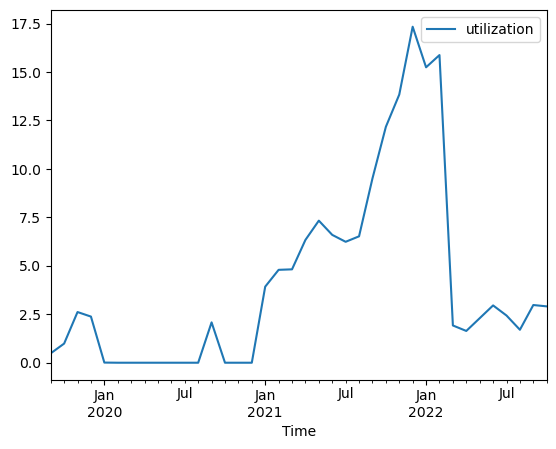

In [14]:
df_agg[['utilization']].plot()

In [15]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [16]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps, n_future):
    df_copy = dc(df)

    #df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df_copy[f'util(t-{i})'] = df_copy['utilization'].shift(i)
    
    for i in range(0, n_future):
        df_copy[f'utilization(t+{i})'] = df_copy['utilization'].shift(-i)
    
    df_copy.dropna(inplace=True)
    df_copy.drop(columns='utilization', inplace=True)

    return df_copy

lookback = 6
future_steps = 6
shifted_df = prepare_dataframe_for_lstm(df_agg[['utilization']], lookback, future_steps)
shifted_df

,util(t-1),util(t-2),util(t-3),util(t-4),util(t-5),util(t-6),utilization(t+0),utilization(t+1),utilization(t+2),utilization(t+3),utilization(t+4),utilization(t+5)
Time,,,,,,,,,,,,
2020-03-31,0.000000,0.007331,2.380865,2.615109,0.987903,0.484559,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-04-30,0.000000,0.000000,0.007331,2.380865,2.615109,0.987903,0.000000,0.000000,0.000000,0.000000,0.000000,2.082281
2020-05-31,0.000000,0.000000,0.000000,0.007331,2.380865,2.615109,0.000000,0.000000,0.000000,0.000000,2.082281,0.000000
2020-06-30,0.000000,0.000000,0.000000,0.000000,0.007331,2.380865,0.000000,0.000000,0.000000,2.082281,0.000000,0.000000
2020-07-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.007331,0.000000,0.000000,2.082281,0.000000,0.000000,0.000000
2020-08-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.082281,0.000000,0.000000,0.000000,3.924935
2020-09-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.082281,0.000000,0.000000,0.000000,3.924935,4.793019
2020-10-31,2.082281,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.924935,4.793019,4.818752
2020-11-30,0.000000,2.082281,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.924935,4.793019,4.818752,6.336490


<AxesSubplot:>

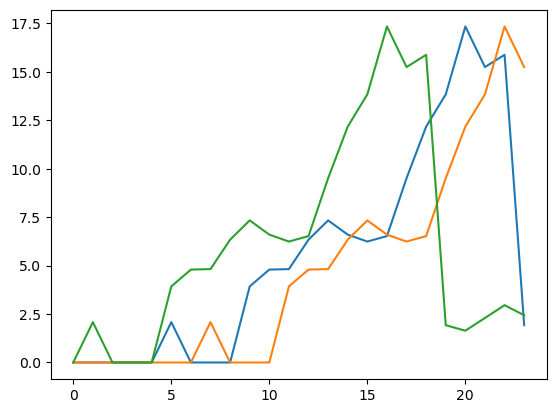

In [17]:
shifted_df['utilization(t+0)'][1:25].reset_index(drop=True).plot()
shifted_df['util(t-1)'][:24].reset_index(drop=True).plot()
shifted_df['utilization(t+2)'][3:27].reset_index(drop=True).plot()
#shifted_df['util(t+1)'][:50].plot()

In [18]:
len(shifted_df)

27

In [19]:
x = shifted_df.filter(regex='t-')
x

,util(t-1),util(t-2),util(t-3),util(t-4),util(t-5),util(t-6)
Time,,,,,,
2020-03-31,0.000000,0.007331,2.380865,2.615109,0.987903,0.484559
2020-04-30,0.000000,0.000000,0.007331,2.380865,2.615109,0.987903
2020-05-31,0.000000,0.000000,0.000000,0.007331,2.380865,2.615109
2020-06-30,0.000000,0.000000,0.000000,0.000000,0.007331,2.380865
2020-07-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.007331
2020-08-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-09-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-10-31,2.082281,0.000000,0.000000,0.000000,0.000000,0.000000
2020-11-30,0.000000,2.082281,0.000000,0.000000,0.000000,0.000000


In [20]:
y = shifted_df.filter(regex='utilization')
y

,utilization(t+0),utilization(t+1),utilization(t+2),utilization(t+3),utilization(t+4),utilization(t+5)
Time,,,,,,
2020-03-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-04-30,0.000000,0.000000,0.000000,0.000000,0.000000,2.082281
2020-05-31,0.000000,0.000000,0.000000,0.000000,2.082281,0.000000
2020-06-30,0.000000,0.000000,0.000000,2.082281,0.000000,0.000000
2020-07-31,0.000000,0.000000,2.082281,0.000000,0.000000,0.000000
2020-08-31,0.000000,2.082281,0.000000,0.000000,0.000000,3.924935
2020-09-30,2.082281,0.000000,0.000000,0.000000,3.924935,4.793019
2020-10-31,0.000000,0.000000,0.000000,3.924935,4.793019,4.818752
2020-11-30,0.000000,0.000000,3.924935,4.793019,4.818752,6.336490


In [21]:
y_np = y.to_numpy()
x_np = x.to_numpy()
y_np

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         2.08228114],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  2.08228114,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  2.08228114,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  2.08228114,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  2.08228114,  0.        ,  0.        ,  0.        ,
         3.92493483],
       [ 2.08228114,  0.        ,  0.        ,  0.        ,  3.92493483,
         4.79301948],
       [ 0.        ,  0.        ,  0.        ,  3.92493483,  4.79301948,
         4.81875204],
       [ 0.        ,  0.        ,  3.92493483,  4.79301948,  4.81875204,
         6.3364899 ],
       [ 0.        ,  3.92493483,  4.79301948,  4.81875204,  6.3364899 ,
         7.3313783 ],
       [ 3.92493483,  4.79301948,  4.81875204,  6.

In [22]:
x_np

array([[0.00000000e+00, 7.33137830e-03, 2.38086510e+00, 2.61510943e+00,
        9.87903226e-01, 4.84559196e-01],
       [0.00000000e+00, 0.00000000e+00, 7.33137830e-03, 2.38086510e+00,
        2.61510943e+00, 9.87903226e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.33137830e-03,
        2.38086510e+00, 2.61510943e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        7.33137830e-03, 2.38086510e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 7.33137830e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [2.08228114e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.08228114e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 

In [23]:
X = x_np.copy()
Y = y_np.copy()

X.shape, Y.shape

((27, 6), (27, 6))

In [24]:
X

array([[0.00000000e+00, 7.33137830e-03, 2.38086510e+00, 2.61510943e+00,
        9.87903226e-01, 4.84559196e-01],
       [0.00000000e+00, 0.00000000e+00, 7.33137830e-03, 2.38086510e+00,
        2.61510943e+00, 9.87903226e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.33137830e-03,
        2.38086510e+00, 2.61510943e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        7.33137830e-03, 2.38086510e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 7.33137830e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [2.08228114e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.08228114e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 

In [25]:
split_index_train = int(len(X) * 0.7)
split_index_test = int(len(X) * 0.1)

split_index_train

18

In [26]:
X_train = X[:split_index_train]
X_val = X[split_index_train:split_index_test + split_index_train]
X_test = X[split_index_test + split_index_train:]

y_train = Y[:split_index_train]
y_val = Y[split_index_train:split_index_test + split_index_train]
y_test = Y[split_index_test + split_index_train:]


X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((18, 6), (2, 6), (7, 6), (18, 6), (2, 6), (7, 6))

In [70]:
X_train = X_train.reshape((-1, lookback, 1))
X_val = X_val.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, future_steps, 1))
y_val = y_val.reshape((-1, future_steps, 1))
y_test = y_test.reshape((-1, future_steps, 1))

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

(torch.Size([18, 6, 1]),
 torch.Size([2, 6, 1]),
 torch.Size([7, 6, 1]),
 torch.Size([18, 6, 1]),
 torch.Size([2, 6, 1]),
 torch.Size([7, 6, 1]))

In [71]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_val = torch.tensor(X_val).float()
y_val = torch.tensor(y_val).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

C:\Users\ZVNE\AppData\Local\Temp\ipykernel_24484\680061179.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).float()
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_24484\680061179.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train).float()
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_24484\680061179.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val).float()
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_24484\680061179.py:4: UserWarning: To copy construct

(torch.Size([18, 6, 1]),
 torch.Size([7, 6, 1]),
 torch.Size([18, 6, 1]),
 torch.Size([7, 6, 1]))

In [72]:
train_size = y_train.shape[0]
val_size = y_val.shape[0]
test_size = y_test.shape[0]

In [73]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [74]:
from torch.utils.data import DataLoader

batch_size = 6

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = False)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle = False)

In [75]:
for x,y in train_loader:
    print(x.to(device).shape, y.to(device).shape)
    break
    
# this is a random check of data shape

torch.Size([6, 6, 1]) torch.Size([6, 6, 1])


### 2. Implementation of the ML method

LSTM model is developed - the same as for the short term forecasting.

In [76]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, :, :])
        return out


In [77]:
# Function to calculate the mean squared error
def calculate_mse(y_true, y_pred):
    return mean_squared_error(y_true.detach().squeeze().numpy(), y_pred.detach().squeeze().numpy())


In [78]:
# these are additional lists and dataframes that are used to save results
train_loss_list = []
train_mse_list = []
test_loss_list = []
test_mse_list = []
epoch_list = []
predicted_values_consumption = pd.DataFrame()
predicted_values_utilization = pd.DataFrame()
real_values_consumption = pd.DataFrame()
real_values_utilization = pd.DataFrame()

pred_consumption_test = pd.DataFrame()
pred_utilization_test = pd.DataFrame()
real_consumption_test = pd.DataFrame()
real_utilization_test = pd.DataFrame()

In [79]:
learning_rate = 0.001
num_epochs = 2000

model = LSTM(1, 2, 2, future_steps)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

counter = 0

for epoch in range(num_epochs):
    
    train_loss = 0.0
    val_loss = 0.0
    train_mse = 0.0
    val_mse = 0.0
    
    # Initialize hidden state
    #hidden = None
    
    # Training
    model.train()
    for inputs, labels in train_loader:
        #print(inputs.unsqueeze(2).shape)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        train_mse += calculate_mse(labels, outputs)
        #print('Train loss:', loss.item())
    

    # Testing
    model.eval()
    
    # *_pom1 is a list that is used for storing values related to the energy consumption
    # *_pom2 is a list that is used for storing values related to the utilization
    predicted_values_pom1 = []
    predicted_values_pom2 = []
    real_values_pom1 = []
    real_values_pom2 = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # print('Outputs shape: ', outputs.squeeze().shape)
            predicted_values_pom1 += outputs.squeeze().numpy()[:, 0].tolist()
            predicted_values_pom2 += outputs.squeeze().numpy()[:, 1].tolist()
            real_values_pom1 += labels.numpy()[:, 0].tolist()
            real_values_pom2 += labels.numpy()[:, 1].tolist()
            val_loss += loss.item() * inputs.size(0)
            val_mse += calculate_mse(labels, outputs)
            
    if epoch == 0:
        real_values_consumption['Epoch ' + str(epoch)] = real_values_pom1
        real_values_utilization['Epoch ' + str(epoch)] = real_values_pom2
        
        # in the first epoch, the calculated losses are considered minimal -> in later epochs it is checked whether the loss is reducing
        val_loss_old = (val_loss/val_size)
        min_val_loss = val_loss_old
        min_weights = model.state_dict()
        
    if epoch > 0:
        val_loss_new = val_loss/val_size
        if val_loss_new > min_val_loss: # some kind of an Early Stopping callback
            counter += 1
        else:
            predicted_values_consumption['The best epoch'] = predicted_values_pom1
            predicted_values_utilization['The best epoch'] = predicted_values_pom2
            min_val_loss = val_loss_new
            
            # if the loss is reducing, current weights and model are saved
            min_weights = model.state_dict()
            best_model = model
            counter = 0
            print('Currently best epoch: ', epoch)
            print('Minimum validation loss: ', min_val_loss)
        
    if epoch%20 == 0:
        # Print training and test errors
        print(f"Epoch {epoch}/{num_epochs} - Training Loss: {train_loss/train_size:.4f} - Val Loss: {val_loss/val_size:.4f} - Train MSE: {train_mse/val_size:.4f} - Val MSE: {val_mse/val_size:.4f}")
        train_loss_list.append(train_loss/train_size)
        train_mse_list.append(train_mse/train_size)
        test_loss_list.append(val_loss/val_size)
        test_mse_list.append(val_mse/val_size)
        epoch_list.append(epoch)
        predicted_values_consumption['Epoch ' + str(epoch)] = predicted_values_pom1
        predicted_values_utilization['Epoch ' + str(epoch)] = predicted_values_pom2
        
    if counter == 30: 
        # If the loss hasn't reduced for 30 epochs, stop training
        print(f"[Early stopping] Epoch {epoch}/{num_epochs} - Train MSE: {train_mse/train_size:.4f} - Val MSE: {val_mse/val_size:.4f}")
        print(f"[Early stopping] Epoch {epoch}/{num_epochs} - Train loss: {train_loss/train_size:.4f} - Val loss: {val_loss/val_size:.4f}")
        print('Minimum validation loss: ', min_val_loss)
        print('Current validation loss: ', val_loss_new)
        train_loss_list.append(train_loss/train_size)
        train_mse_list.append(train_mse/train_size)
        test_loss_list.append(val_loss/val_size)
        test_mse_list.append(val_mse/val_size)
        epoch_list.append(epoch)
        predicted_values_consumption['Epoch ' + str(epoch)] = predicted_values_pom1
        predicted_values_utilization['Epoch ' + str(epoch)] = predicted_values_pom2
        break
        
    

Epoch 0/2000 - Training Loss: 32.3227 - Val Loss: 174.3117 - Train MSE: 48.4841 - Val MSE: 87.1558
Currently best epoch:  1
Minimum validation loss:  173.6655731201172
Currently best epoch:  2
Minimum validation loss:  173.13059997558594
Currently best epoch:  3
Minimum validation loss:  172.65533447265625
Currently best epoch:  4
Minimum validation loss:  172.2184295654297
Currently best epoch:  5
Minimum validation loss:  171.80857849121094
Currently best epoch:  6
Minimum validation loss:  171.41896057128906
Currently best epoch:  7
Minimum validation loss:  171.0450897216797
Currently best epoch:  8
Minimum validation loss:  170.68382263183594
Currently best epoch:  9
Minimum validation loss:  170.3329315185547
Currently best epoch:  10
Minimum validation loss:  169.99070739746094
Currently best epoch:  11
Minimum validation loss:  169.65586853027344
Currently best epoch:  12
Minimum validation loss:  169.32737731933594
Currently best epoch:  13
Minimum validation loss:  169.004470

Currently best epoch:  116
Minimum validation loss:  145.12205505371094
Currently best epoch:  117
Minimum validation loss:  144.95455932617188
Currently best epoch:  118
Minimum validation loss:  144.7880859375
Currently best epoch:  119
Minimum validation loss:  144.62255859375
Currently best epoch:  120
Minimum validation loss:  144.45802307128906
Epoch 120/2000 - Training Loss: 24.0907 - Val Loss: 144.4580 - Train MSE: 36.1361 - Val MSE: 72.2290
Currently best epoch:  121
Minimum validation loss:  144.29444885253906
Currently best epoch:  122
Minimum validation loss:  144.13177490234375
Currently best epoch:  123
Minimum validation loss:  143.97006225585938
Currently best epoch:  124
Minimum validation loss:  143.8092498779297
Currently best epoch:  125
Minimum validation loss:  143.6493377685547
Currently best epoch:  126
Minimum validation loss:  143.49032592773438
Currently best epoch:  127
Minimum validation loss:  143.3321990966797
Currently best epoch:  128
Minimum validation

Currently best epoch:  242
Minimum validation loss:  128.9453887939453
Currently best epoch:  243
Minimum validation loss:  128.8411407470703
Currently best epoch:  244
Minimum validation loss:  128.737060546875
Currently best epoch:  245
Minimum validation loss:  128.6331329345703
Currently best epoch:  246
Minimum validation loss:  128.52938842773438
Currently best epoch:  247
Minimum validation loss:  128.42576599121094
Currently best epoch:  248
Minimum validation loss:  128.3223114013672
Currently best epoch:  249
Minimum validation loss:  128.2189483642578
Currently best epoch:  250
Minimum validation loss:  128.11572265625
Currently best epoch:  251
Minimum validation loss:  128.01258850097656
Currently best epoch:  252
Minimum validation loss:  127.9095687866211
Currently best epoch:  253
Minimum validation loss:  127.80663299560547
Currently best epoch:  254
Minimum validation loss:  127.7037582397461
Currently best epoch:  255
Minimum validation loss:  127.6009750366211
Curre

Currently best epoch:  367
Minimum validation loss:  115.72140502929688
Currently best epoch:  368
Minimum validation loss:  115.61846923828125
Currently best epoch:  369
Minimum validation loss:  115.51565551757812
Currently best epoch:  370
Minimum validation loss:  115.4129409790039
Currently best epoch:  371
Minimum validation loss:  115.31036376953125
Currently best epoch:  372
Minimum validation loss:  115.20792388916016
Currently best epoch:  373
Minimum validation loss:  115.1056137084961
Currently best epoch:  374
Minimum validation loss:  115.0033950805664
Currently best epoch:  375
Minimum validation loss:  114.90133666992188
Currently best epoch:  376
Minimum validation loss:  114.79940032958984
Currently best epoch:  377
Minimum validation loss:  114.69757843017578
Currently best epoch:  378
Minimum validation loss:  114.59588623046875
Currently best epoch:  379
Minimum validation loss:  114.49430084228516
Currently best epoch:  380
Minimum validation loss:  114.3928604125

Currently best epoch:  502
Minimum validation loss:  102.96923065185547
Currently best epoch:  503
Minimum validation loss:  102.88314819335938
Currently best epoch:  504
Minimum validation loss:  102.79720306396484
Currently best epoch:  505
Minimum validation loss:  102.71137237548828
Currently best epoch:  506
Minimum validation loss:  102.62564849853516
Currently best epoch:  507
Minimum validation loss:  102.5400619506836
Currently best epoch:  508
Minimum validation loss:  102.45455932617188
Currently best epoch:  509
Minimum validation loss:  102.36920166015625
Currently best epoch:  510
Minimum validation loss:  102.28394317626953
Currently best epoch:  511
Minimum validation loss:  102.19879150390625
Currently best epoch:  512
Minimum validation loss:  102.11377716064453
Currently best epoch:  513
Minimum validation loss:  102.02886962890625
Currently best epoch:  514
Minimum validation loss:  101.94408416748047
Currently best epoch:  515
Minimum validation loss:  101.85941314

Currently best epoch:  618
Minimum validation loss:  93.7339096069336
Currently best epoch:  619
Minimum validation loss:  93.66057586669922
Currently best epoch:  620
Minimum validation loss:  93.58736419677734
Epoch 620/2000 - Training Loss: 13.6878 - Val Loss: 93.5874 - Train MSE: 20.5316 - Val MSE: 46.7937
Currently best epoch:  621
Minimum validation loss:  93.51424407958984
Currently best epoch:  622
Minimum validation loss:  93.44123077392578
Currently best epoch:  623
Minimum validation loss:  93.36831665039062
Currently best epoch:  624
Minimum validation loss:  93.29552459716797
Currently best epoch:  625
Minimum validation loss:  93.22280883789062
Currently best epoch:  626
Minimum validation loss:  93.15020751953125
Currently best epoch:  627
Minimum validation loss:  93.07772064208984
Currently best epoch:  628
Minimum validation loss:  93.00533294677734
Currently best epoch:  629
Minimum validation loss:  92.93304443359375
Currently best epoch:  630
Minimum validation los

Currently best epoch:  729
Minimum validation loss:  86.20038604736328
Currently best epoch:  730
Minimum validation loss:  86.13773345947266
Currently best epoch:  731
Minimum validation loss:  86.0751724243164
Currently best epoch:  732
Minimum validation loss:  86.01270294189453
Currently best epoch:  733
Minimum validation loss:  85.95032501220703
Currently best epoch:  734
Minimum validation loss:  85.88803100585938
Currently best epoch:  735
Minimum validation loss:  85.8258056640625
Currently best epoch:  736
Minimum validation loss:  85.76367950439453
Currently best epoch:  737
Minimum validation loss:  85.7016372680664
Currently best epoch:  738
Minimum validation loss:  85.63968658447266
Currently best epoch:  739
Minimum validation loss:  85.57781982421875
Currently best epoch:  740
Minimum validation loss:  85.51602935791016
Epoch 740/2000 - Training Loss: 12.4936 - Val Loss: 85.5160 - Train MSE: 18.7404 - Val MSE: 42.7580
Currently best epoch:  741
Minimum validation loss:

Currently best epoch:  844
Minimum validation loss:  79.52046203613281
Currently best epoch:  845
Minimum validation loss:  79.46666717529297
Currently best epoch:  846
Minimum validation loss:  79.41294860839844
Currently best epoch:  847
Minimum validation loss:  79.35930633544922
Currently best epoch:  848
Minimum validation loss:  79.30572509765625
Currently best epoch:  849
Minimum validation loss:  79.252197265625
Currently best epoch:  850
Minimum validation loss:  79.1987533569336
Currently best epoch:  851
Minimum validation loss:  79.1453628540039
Currently best epoch:  852
Minimum validation loss:  79.09204864501953
Currently best epoch:  853
Minimum validation loss:  79.03878784179688
Currently best epoch:  854
Minimum validation loss:  78.98561096191406
Currently best epoch:  855
Minimum validation loss:  78.93248748779297
Currently best epoch:  856
Minimum validation loss:  78.87943267822266
Currently best epoch:  857
Minimum validation loss:  78.82644653320312
Currently 

Currently best epoch:  953
Minimum validation loss:  74.02381896972656
Currently best epoch:  954
Minimum validation loss:  73.97675323486328
Currently best epoch:  955
Minimum validation loss:  73.92975616455078
Currently best epoch:  956
Minimum validation loss:  73.8828353881836
Currently best epoch:  957
Minimum validation loss:  73.83597564697266
Currently best epoch:  958
Minimum validation loss:  73.7891845703125
Currently best epoch:  959
Minimum validation loss:  73.74246215820312
Currently best epoch:  960
Minimum validation loss:  73.6958236694336
Epoch 960/2000 - Training Loss: 10.8743 - Val Loss: 73.6958 - Train MSE: 16.3115 - Val MSE: 36.8479
Currently best epoch:  961
Minimum validation loss:  73.64923858642578
Currently best epoch:  962
Minimum validation loss:  73.60272979736328
Currently best epoch:  963
Minimum validation loss:  73.5562973022461
Currently best epoch:  964
Minimum validation loss:  73.50993347167969
Currently best epoch:  965
Minimum validation loss: 

Currently best epoch:  1071
Minimum validation loss:  68.9617919921875
Currently best epoch:  1072
Minimum validation loss:  68.92292022705078
Currently best epoch:  1073
Minimum validation loss:  68.88410186767578
Currently best epoch:  1074
Minimum validation loss:  68.84535217285156
Currently best epoch:  1075
Minimum validation loss:  68.8066635131836
Currently best epoch:  1076
Minimum validation loss:  68.76802825927734
Currently best epoch:  1077
Minimum validation loss:  68.72946166992188
Currently best epoch:  1078
Minimum validation loss:  68.69095611572266
Currently best epoch:  1079
Minimum validation loss:  68.65251922607422
Currently best epoch:  1080
Minimum validation loss:  68.61415100097656
Epoch 1080/2000 - Training Loss: 10.2148 - Val Loss: 68.6142 - Train MSE: 15.3223 - Val MSE: 34.3071
Currently best epoch:  1081
Minimum validation loss:  68.5758285522461
Currently best epoch:  1082
Minimum validation loss:  68.5375747680664
Currently best epoch:  1083
Minimum val

Currently best epoch:  1189
Minimum validation loss:  64.78807067871094
Currently best epoch:  1190
Minimum validation loss:  64.75617218017578
Currently best epoch:  1191
Minimum validation loss:  64.72431182861328
Currently best epoch:  1192
Minimum validation loss:  64.6925277709961
Currently best epoch:  1193
Minimum validation loss:  64.6607894897461
Currently best epoch:  1194
Minimum validation loss:  64.62911224365234
Currently best epoch:  1195
Minimum validation loss:  64.59749603271484
Currently best epoch:  1196
Minimum validation loss:  64.5659408569336
Currently best epoch:  1197
Minimum validation loss:  64.53443145751953
Currently best epoch:  1198
Minimum validation loss:  64.50299072265625
Currently best epoch:  1199
Minimum validation loss:  64.47161102294922
Currently best epoch:  1200
Minimum validation loss:  64.4402847290039
Epoch 1200/2000 - Training Loss: 9.6812 - Val Loss: 64.4403 - Train MSE: 14.5218 - Val MSE: 32.2201
Currently best epoch:  1201
Minimum vali

Currently best epoch:  1307
Minimum validation loss:  61.4404182434082
Currently best epoch:  1308
Minimum validation loss:  61.41595458984375
Currently best epoch:  1309
Minimum validation loss:  61.39155960083008
Currently best epoch:  1310
Minimum validation loss:  61.36723709106445
Currently best epoch:  1311
Minimum validation loss:  61.34300231933594
Currently best epoch:  1312
Minimum validation loss:  61.31883239746094
Currently best epoch:  1313
Minimum validation loss:  61.29472732543945
Currently best epoch:  1314
Minimum validation loss:  61.270721435546875
Currently best epoch:  1315
Minimum validation loss:  61.24678039550781
Currently best epoch:  1316
Minimum validation loss:  61.22291946411133
Currently best epoch:  1317
Minimum validation loss:  61.19914627075195
Currently best epoch:  1318
Minimum validation loss:  61.175445556640625
Currently best epoch:  1319
Minimum validation loss:  61.15181350708008
Currently best epoch:  1320
Minimum validation loss:  61.128276

Currently best epoch:  1414
Minimum validation loss:  59.34336471557617
Currently best epoch:  1415
Minimum validation loss:  59.32887268066406
Currently best epoch:  1416
Minimum validation loss:  59.31443405151367
Currently best epoch:  1417
Minimum validation loss:  59.30003356933594
Currently best epoch:  1418
Minimum validation loss:  59.28569412231445
Currently best epoch:  1419
Minimum validation loss:  59.27138900756836
Currently best epoch:  1420
Minimum validation loss:  59.25712585449219
Epoch 1420/2000 - Training Loss: 8.8129 - Val Loss: 59.2571 - Train MSE: 13.2194 - Val MSE: 29.6286
Currently best epoch:  1421
Minimum validation loss:  59.242889404296875
Currently best epoch:  1422
Minimum validation loss:  59.228702545166016
Currently best epoch:  1423
Minimum validation loss:  59.21455001831055
Currently best epoch:  1424
Minimum validation loss:  59.20041275024414
Currently best epoch:  1425
Minimum validation loss:  59.18630599975586
Currently best epoch:  1426
Minimu

Currently best epoch:  1530
Minimum validation loss:  57.51572799682617
Currently best epoch:  1531
Minimum validation loss:  57.496456146240234
Currently best epoch:  1532
Minimum validation loss:  57.477142333984375
Currently best epoch:  1533
Minimum validation loss:  57.45779800415039
Currently best epoch:  1534
Minimum validation loss:  57.438411712646484
Currently best epoch:  1535
Minimum validation loss:  57.41899490356445
Currently best epoch:  1536
Minimum validation loss:  57.399539947509766
Currently best epoch:  1537
Minimum validation loss:  57.38006591796875
Currently best epoch:  1538
Minimum validation loss:  57.36056137084961
Currently best epoch:  1539
Minimum validation loss:  57.341033935546875
Currently best epoch:  1540
Minimum validation loss:  57.32148361206055
Epoch 1540/2000 - Training Loss: 8.3862 - Val Loss: 57.3215 - Train MSE: 12.5794 - Val MSE: 28.6607
Currently best epoch:  1541
Minimum validation loss:  57.301910400390625
Currently best epoch:  1542
Mi

Currently best epoch:  1639
Minimum validation loss:  55.58488464355469
Currently best epoch:  1640
Minimum validation loss:  55.57204055786133
Epoch 1640/2000 - Training Loss: 8.1278 - Val Loss: 55.5720 - Train MSE: 12.1917 - Val MSE: 27.7860
Currently best epoch:  1641
Minimum validation loss:  55.55936050415039
Currently best epoch:  1642
Minimum validation loss:  55.54683303833008
Currently best epoch:  1643
Minimum validation loss:  55.53445816040039
Currently best epoch:  1644
Minimum validation loss:  55.52225875854492
Currently best epoch:  1645
Minimum validation loss:  55.51022720336914
Currently best epoch:  1646
Minimum validation loss:  55.49837112426758
Currently best epoch:  1647
Minimum validation loss:  55.4866828918457
Currently best epoch:  1648
Minimum validation loss:  55.47518539428711
Currently best epoch:  1649
Minimum validation loss:  55.4638671875
Currently best epoch:  1650
Minimum validation loss:  55.452728271484375
Currently best epoch:  1651
Minimum vali

In [80]:
outputs.shape

torch.Size([2, 6, 1])

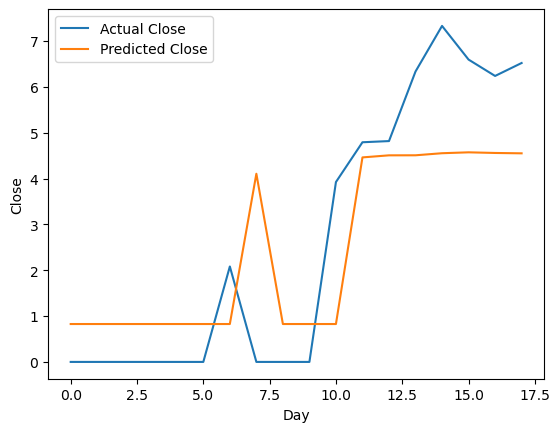

In [81]:
with torch.no_grad():
    predicted = best_model(X_train.to(device)).to('cpu').numpy()
    
plt.plot(y_train[0:24, 0, :], label='Actual Close')
plt.plot(predicted[0:24, 0, :], label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [82]:
y_train.shape

torch.Size([18, 6, 1])

In [83]:
test_predictions = best_model(X_test.to(device)).detach().cpu().numpy()

In [84]:
# Function to calculate the mean squared error
def calculate_mse(y_true, y_pred):
    return mean_squared_error(y_true.squeeze(), y_pred.squeeze())

calculate_mse(test_predictions, y_test)/test_size

6.258117130824497

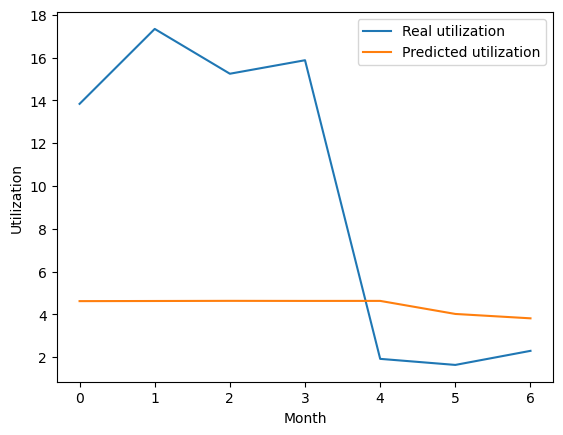

In [86]:
# Prediction results when aggregating (monthly) then shifting

plt.plot(y_test[0:20, 0, :], label='Real utilization')
plt.plot(test_predictions[0:20, 0, :], label='Predicted utilization')
plt.xlabel('Month')
plt.ylabel('Utilization')
plt.legend()
plt.show()